# MNIST classifier in IBM FL

## Outline:
- [Add conda environment to Jupyter Notebook](#setup)
- [Federated Learning(FL)](#intro)
- [Digit Recognition](#mnist)
- [Aggregator](#Aggregator)
    - [Aggregator Configuration](#Aggregator-Configuration)
    - [Running the Aggregator](#Running-the-Aggregator)
- [Parties](#Parties)
    - [Party Setup](#Party-Setup)
- [Training and Evaluation](#Training-and-Evaluation)
- [Visualize Results](#Visualize-Results)
- [Shut Down](#Shut-Down)

## Add conda environment to Jupyter Notebook <a name="setup"></a>

Please ensure that you have activated the `conda` environment following the instructions in the project README.

Once done, run the following commands in your terminal to install your conda environment into the Jupyter Notebook:

1. Once you have activated the conda environment, install the `ipykernel` package: `conda install -c anaconda ipykernel`

2. Next, install the `ipykernel` module within Jupyter Notebook: `python -m ipykernel install --user --name=<conda_env>`

3. Please install the `matplotlib` package for your conda environment.

4. Finally, restart the jupyter notebook once done. Ensure that you are running this Notebook from `<project_path>/examples/keras_classifier`, where project_path is the directory where the IBMFL repository was cloned.

When the Notebook is up and running it may prompt you to choose the kernel. Use the drop down to choose the kernel name same as that chosen when running `conda activate <conda_env>`. If no prompt shows up, you can change the kernel by clicking _Kernel_ > _Change kernel_ > _`<conda_env>`_.

## Federated Learning (FL) <a name="intro"></a>

**Federated Learning (FL)** is a distributed machine learning process in which each participant node (or party) retains their data locally and interacts with  other participants via a learning protocol. 
One main driver behind FL is the need to not share data with others  due to privacy and confidentially concerns.
Another driver is to improve the speed of training a machine learning model by leveraging other participants' training processes.

Setting up such a federated learning system requires setting up a communication infrastructure, converting machine learning algorithms to federated settings and in some cases knowing about the intricacies of security and privacy enabling techniques such as differential privacy and multi-party computation. 

In this Notebook we use [IBM FL](https://github.ibm.com/FederatedLearning/FFL) to have multiple parties train a classifier to recognise handwritten digits in the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). 

For a more technical dive into IBM FL, refer the whitepaper [here](https://arxiv.org/pdf/2007.10987.pdf).

In the following cells, we set up each of the components of a Federated Learning network (See Figure below) wherein all involved parties aid in training their respective local cartpoles to arrive at the upright pendulum state. In this notebook we default to 5 parties, but depending on your resources you may use fewer parties.

<img src="images/FL_Network.png" width="720"/>
<figcaption><center>Modified from Image Source: <a href="https://arxiv.org/pdf/2007.10987.pdf">IBM Federated Learning: An Enterprise FrameworkWhite Paper V0.1</a></center></figcaption>

## Digit Recognition <a name="mnist"></a>



<img src="images/MnistExamples.png" width="512"/>
<figcaption><center>Image Source: Josef Steppan / CC BY-SA <a href="https://creativecommons.org/licenses/by-sa/4.0">Wikimedia Commons</a></center></figcaption>

The problem at hand is to recognize digits from these tens of thousands of handwritten images. In this notebook, we are going to assume that the parties and the aggregator are run in the same machine. For that purpose, we first randomly split the training data to each party. Then, we define the neural network definition. After that we start the aggregator and we need to register and run all parties by running two other notebooks.

### Getting things ready
We begin by setting the number of parties that will participate in the federated learning run and splitting up the data among them.

In [1]:
import sys
sys.path.append('../..')
import os
os.chdir("../..")

num_parties = 2  ## number of participating parties
dataset = 'mnist'

We use `examples/generate_data.py` to split the dataset into files for each party. 

The script allows specifying the number of parties as well as the dataset to use (from several supported datasets: _mnist_, _femnist_, _cifar10_ and many others). 

The `-pp` argument states how many data points to choose per party. If the option `--stratify` is given, the library stratifies the data proportionally according to the source distribution. If you want to run this notebook in different machines, you can assign samples for each party locally. Then, we define the neural network definition.

In [2]:
%run examples/generate_data.py -n $num_parties -d $dataset -pp 200 

Party_ 0
nb_x_train:  (200, 28, 28) nb_x_test:  (5000, 28, 28)
* Label  0  samples:  22
* Label  1  samples:  26
* Label  2  samples:  15
* Label  3  samples:  22
* Label  4  samples:  17
* Label  5  samples:  19
* Label  6  samples:  17
* Label  7  samples:  25
* Label  8  samples:  16
* Label  9  samples:  21
Finished! :) Data saved in  examples/data/mnist/random
Party_ 1
nb_x_train:  (200, 28, 28) nb_x_test:  (5000, 28, 28)
* Label  0  samples:  14
* Label  1  samples:  18
* Label  2  samples:  19
* Label  3  samples:  16
* Label  4  samples:  26
* Label  5  samples:  18
* Label  6  samples:  17
* Label  7  samples:  28
* Label  8  samples:  21
* Label  9  samples:  23
Finished! :) Data saved in  examples/data/mnist/random


Generate the keras model definition file using the below function save_model_config. Please note that parties data and the model file needs to be copied to the parties if you launch parties on different nodes.

In [3]:
import os

import keras
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential
def save_model_config(folder_configs):
    num_classes = 10
    img_rows, img_cols = 28, 28
    if K.image_data_format() == 'channels_first':
        input_shape = (1, img_rows, img_cols)
    else:
        input_shape = (img_rows, img_cols, 1)

    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

    if not os.path.exists(folder_configs):
        os.makedirs(folder_configs)

    # Save model
    fname = os.path.join(folder_configs, 'compiled_keras.h5')
    model.save(fname)
    print(fname)

    K.clear_session()
    # Generate model spec:
    spec = {
        'model_name': 'keras-cnn',
        'model_definition': fname
    }

    model = {
        'name': 'KerasFLModel',
        'path': 'ibmfl.model.keras_fl_model',
        'spec': spec
    }

    return model
save_model_config('examples/configs/keras_classifier')

Using TensorFlow backend.
//anaconda2/envs/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
//anaconda2/envs/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
//anaconda2/envs/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
//anaconda2/envs/myenv/lib/python3.6/site-packages/tenso

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
examples/configs/keras_classifier/compiled_keras.h5


{'name': 'KerasFLModel',
 'path': 'ibmfl.model.keras_fl_model',
 'spec': {'model_name': 'keras-cnn',
  'model_definition': 'examples/configs/keras_classifier/compiled_keras.h5'}}

## Aggregator

coordinates the overall process, communicates with the parties and integrates the results of the training process. This integration of results is done using the _Fusion Algorithm_.

A fusion algorithm queries the registered parties to carry out the federated learning process. The queries sent vary according to the model/algorithm type.  In return, parties send their reply as a model update object, and these model updates are then aggregated according to the specified Fusion Algorithm, specified via a `Fusion Handler` class. 

To take a look at the supported fusion algorithms, refer the IBM FL tutorial page [here](https://ibmfl.mybluemix.net/api-documentation).

### Aggregator Configuration

We discuss the various configuration parameters for the Aggregator [here.](https://github.com/IBM/federated-learning-lib/blob/main/docs/tutorials/configure_fl.md#the-aggregators-configuration-file)

Given below is an example of the aggregator's configuration file. In this example, the aggregator does not specify a data file or maintain a global model. Hence, during the federated learning process, it only keeps track of the current model parameters. 

However, it is possible that the aggregator also has data for testing purposes and maintains a global model. When this is the case, one needs to add `data` and `model` sections in the configuration file.

<img src="images/arch_aggregator.png" width="680"/>
<figcaption><center>Image Source: <a href="https://arxiv.org/pdf/2007.10987.pdf">IBM Federated Learning: An Enterprise FrameworkWhite Paper V0.1</a></center></figcaption>

#### Building blocks in the configuration file:

- `connection` (also used in Party config): needed to initiate the connection; includes server information (`info`, optional, depends on the connection type), a connection class name, a connection file location, and a synchronization mode flag (`sync`) for training phase

- `fusion`: needed to initiate a fusion algorithm at the aggregator side; includes a fusion handler class name and a fusion handler file location

- `protocol_handler`: needed to initiate a protocol; includes a protocol handler class name and a protocol handler file location

- `hyperparams`: includes global training and local training hyperparameters, including `termination_accuracy`, learning rate (`lr`), `optimizer`, etc., depending on the model being used.

For detailed documentation of the objects described below, refer the API docs [here](https://ibmfl.mybluemix.net/api-documentation).

In [4]:
agg_config = {
    'connection': {
        'info': {
            'ip': '127.0.0.1',
            'port': 5000,
            'tls_config': {
                'enable': 'false'
            }
        },
        'name': 'FlaskConnection',
        'path': 'ibmfl.connection.flask_connection',
        'sync': 'False'
    },
    'data': {
        'info': {
            'npz_file': 'examples/datasets/mnist.npz'
        },
        'name': 'MnistKerasDataHandler',
        'path': 'ibmfl.util.data_handlers.mnist_keras_data_handler'
    },
    'fusion': {
        'name': 'IterAvgFusionHandler',
        'path': 'ibmfl.aggregator.fusion.iter_avg_fusion_handler'
    },
    'hyperparams': {
        'global': {
            'max_timeout': 60,
            'num_parties': num_parties,
            'perc_quorum': 1,
            'rounds': 30,
            'termination_accuracy': 0.9
        },
        'local': {
            'optimizer': {
                'lr': 0.01
            },
            'training': {
                'epochs': 3
            }
        }
    },
    'protocol_handler': {
        'name': 'ProtoHandler',
        'path': 'ibmfl.aggregator.protohandler.proto_handler'
    }
}

### Running the Aggregator
Next we pass the configuration parameters set in the previous cell to instantiate the `Aggregator` object. Finally, we `start()` the Aggregator process.

In [5]:

from ibmfl.aggregator.aggregator import Aggregator
aggregator = Aggregator(config_dict=agg_config)

aggregator.start()

2020-10-05 15:17:12,953 -STD ibmfl.util.config - INFO - Getting Aggregator details from arguments.
2020-10-05 15:17:15,881 -STD ibmfl.util.config - INFO - No model config provided for this setup.
2020-10-05 15:17:16,960 -STD ibmfl.util.config - INFO - No local training config provided for this setup.
2020-10-05 15:17:16,963 -STD ibmfl.connection.flask_connection - INFO - RestSender initialized
2020-10-05 15:17:16,968 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - State: States.START
2020-10-05 15:17:16,987 -STD ibmfl.connection.flask_connection - INFO - Receiver Initialized
2020-10-05 15:17:16,997 -STD ibmfl.connection.flask_connection - INFO - Initializing Flask application
2020-10-05 15:17:17,117 -STD ibmfl.aggregator.aggregator - INFO - Aggregator initialization successful
2020-10-05 15:17:17,123 -STD ibmfl.aggregator.aggregator - INFO - Aggregator start successful * Serving Flask app "ibmfl.connection.flask_connection" (lazy loading)
 * Environment: production

   Use a 

<img src="images/arch_party.png" width="680"/>
<figcaption><center>Image Source: <a href="https://arxiv.org/pdf/2007.10987.pdf">IBM Federated Learning: An Enterprise FrameworkWhite Paper V0.1</a></center></figcaption>

## Starting Parties

Now that we have Aggregator running, next we go to Parties' notebooks (`keras_classifier_p0.ipynb` and `keras_classifier_p1.ipynb`) to start and register them with the Aggregator. Once all the parties are done with registration, we will move to next step to start training.

## Training and Evaluation

Now that our network has been set up, we begin training the model by invoking the Aggregator's `start_training()` method. 

This could take some time, depending on your system specifications. Feel free to get your doze of coffee meanwhile ☕

In [6]:
"""
#1 Initialize the metrics collector variables
"""
num_parties = agg_config['hyperparams']['global']['num_parties']
eval_party_accuracy = [[] for _ in range(num_parties)]
iterations = [[] for _ in range(num_parties)]

"""
#2 Register handler for metrics collector
"""
def get_metrics(metrics):
    keys = list(metrics['party'].keys())
    keys.sort()
    for i in range(len(keys)):
      eval_party_accuracy[i].append(metrics['party'][keys[i]]['acc'])
      iterations[i].append(metrics['fusion']['curr_round']*agg_config['hyperparams']['local']['training']['epochs'])
      
mh = aggregator.fusion.metrics_manager
mh.register(get_metrics)


"""
#3 start the training
"""
aggregator.start_training()

2020-10-05 15:18:10,140 -STD ibmfl.aggregator.aggregator - INFO - Initiating Global Training.
2020-10-05 15:18:10,142 -STD ibmfl.aggregator.fusion.fusion_handler - INFO - Warm start disabled.
2020-10-05 15:18:10,144 -STD ibmfl.aggregator.fusion.iter_avg_fusion_handler - INFO - Model updateNone
2020-10-05 15:18:10,145 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - State: States.SND_REQ
2020-10-05 15:18:10,258 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Total number of success responses :2
2020-10-05 15:18:10,260 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - State: States.QUORUM_WAIT
2020-10-05 15:18:10,261 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 2
2020-10-05 15:18:15,268 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:60 Time spent:5
2020-10-05 15:18:15,270 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 2
2020-10-05 15:18:18,858 -STD ibmfl.connection.flask_connection - INFO - 

2020-10-05 15:19:11,878 -STD ibmfl.aggregator.fusion.iter_avg_fusion_handler - INFO - Model update<ibmfl.model.model_update.ModelUpdate object at 0x11966b128>
2020-10-05 15:19:11,881 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - State: States.SND_REQ
2020-10-05 15:19:12,378 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Total number of success responses :2
2020-10-05 15:19:12,380 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - State: States.QUORUM_WAIT
2020-10-05 15:19:12,383 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 2
2020-10-05 15:19:17,390 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:60 Time spent:5
2020-10-05 15:19:17,392 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 2
2020-10-05 15:19:22,399 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:60 Time spent:10
2020-10-05 15:19:22,402 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 2
202

2020-10-05 15:20:14,231 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - State: States.SND_REQ
2020-10-05 15:20:14,950 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Total number of success responses :2
2020-10-05 15:20:14,959 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - State: States.QUORUM_WAIT
2020-10-05 15:20:14,969 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 2
2020-10-05 15:20:19,974 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:60 Time spent:5
2020-10-05 15:20:19,977 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 2
2020-10-05 15:20:24,986 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:60 Time spent:10
2020-10-05 15:20:24,989 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 2
2020-10-05 15:20:29,999 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:60 Time spent:15
2020-10-05 15:20:30,002 -STD ibmfl.aggregator.protohand

2020-10-05 15:21:17,533 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Total number of success responses :2
2020-10-05 15:21:17,535 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - State: States.QUORUM_WAIT
2020-10-05 15:21:17,536 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 2
2020-10-05 15:21:22,543 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:60 Time spent:5
2020-10-05 15:21:22,545 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 2
2020-10-05 15:21:24,013 -STD ibmfl.connection.flask_connection - INFO - Request received for path :7
2020-10-05 15:21:24,099 -STD werkzeug - INFO - 127.0.0.1 - - [05/Oct/2020 15:21:24] "POST /7 HTTP/1.1" 200 -
2020-10-05 15:21:24,162 -STD ibmfl.connection.flask_connection - INFO - Request received for path :7
2020-10-05 15:21:24,270 -STD werkzeug - INFO - 127.0.0.1 - - [05/Oct/2020 15:21:24] "POST /7 HTTP/1.1" 200 -
2020-10-05 15:21:27,551 -STD ibmfl.aggregator.proto

2020-10-05 15:22:08,752 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:60 Time spent:10
2020-10-05 15:22:08,754 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 2
2020-10-05 15:22:08,755 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - State: States.PROC_RSP
2020-10-05 15:22:08,766 -STD ibmfl.aggregator.fusion.iter_avg_fusion_handler - INFO - Model update<ibmfl.model.model_update.ModelUpdate object at 0x11b5f81d0>
2020-10-05 15:22:08,768 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - State: States.SND_REQ
2020-10-05 15:22:09,196 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Total number of success responses :2
2020-10-05 15:22:09,197 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - State: States.QUORUM_WAIT
2020-10-05 15:22:09,198 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 2
2020-10-05 15:22:14,202 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:60 Time spen

2020-10-05 15:22:55,445 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 2
2020-10-05 15:22:57,552 -STD ibmfl.connection.flask_connection - INFO - Request received for path :7
2020-10-05 15:22:57,556 -STD ibmfl.connection.flask_connection - INFO - Request received for path :7
2020-10-05 15:22:57,690 -STD werkzeug - INFO - 127.0.0.1 - - [05/Oct/2020 15:22:57] "POST /7 HTTP/1.1" 200 -
2020-10-05 15:22:57,758 -STD werkzeug - INFO - 127.0.0.1 - - [05/Oct/2020 15:22:57] "POST /7 HTTP/1.1" 200 -
2020-10-05 15:23:00,451 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:60 Time spent:10
2020-10-05 15:23:00,453 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 2
2020-10-05 15:23:00,455 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - State: States.PROC_RSP
2020-10-05 15:23:00,468 -STD ibmfl.aggregator.fusion.iter_avg_fusion_handler - INFO - Model update<ibmfl.model.model_update.ModelUpdate object at 0x10bcc0748>
2020-10-05 15

True

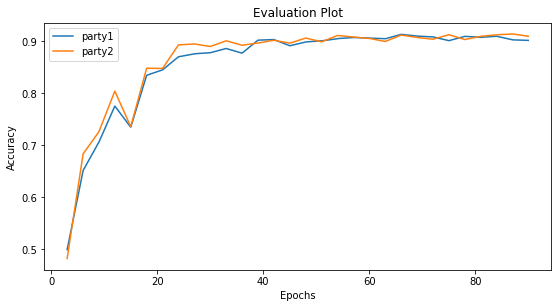

In [7]:
"""
#1 define a method to plot a smooth cure
"""
from matplotlib import pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline
import numpy as np

def smooth_curve(xaxis, yaxis):
   xnew = np.linspace(min(xaxis), max(xaxis), len(xaxis)*50) 

   spl = make_interp_spline(xaxis, yaxis, k=1)  # type: BSpline
   power_smooth = spl(xnew)
   return xnew, power_smooth 

f = plt.figure(figsize=(20,10))
plt.subplot(2, 2, 1)

num_parties = agg_config['hyperparams']['global']['num_parties']


"""
#2 plot the evaluation curve
"""
for i in range(num_parties):
    eval_party_xaxis, eval_party_yaxis = smooth_curve(iterations[i], eval_party_accuracy[i])
    line1, = plt.plot(eval_party_xaxis, eval_party_yaxis)
    line1.set_label('party'+str(i+1))
plt.title('Evaluation Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

## Shut Down

Invoke the `stop()` method on each of the network participants to terminate the service.

In [8]:
aggregator.stop()

2020-10-05 15:23:59,072 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - State: States.SND_REQ
2020-10-05 15:23:59,202 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Total number of success responses :2
2020-10-05 15:23:59,204 -STD ibmfl.connection.flask_connection - INFO - Stopping Receiver and Sender
2020-10-05 15:23:59,214 -STD werkzeug - INFO - 127.0.0.1 - - [05/Oct/2020 15:23:59] "POST /shutdown HTTP/1.1" 200 -
2020-10-05 15:23:59,219 -STD ibmfl.aggregator.aggregator - INFO - Aggregator stop successful


## Visualize Parties' Training
Please go to Parties' notebooks to visalize summary of Parties' training.